# Beeler-Reuter AP Model

This example shows how the Beeler-Reuter action potential (AP) toy model can be used.

The [action potential](https://en.wikipedia.org/wiki/Action_potential) 
    (cell's transmembrane voltage) model contains
    multiple currents which their magnitude is determined by the maximum-
    conductance while their shape is controlled by other parameters. In this
    simplified (but not trivial) action potential toy model, we define the
    maximum-conductance values of all the currents as the parameter of
    interest, and assume all other parameters of the model are known and well-
    defined. We also define the maximum-conductance values in logarithmic
    scale.

The observables of this model are the transmembrane voltage (the action
    potential itsefl) and the calcium concentration of the cell (also known as
    the calcium transient).

For information on the science behind it, see the [original 1977 paper](https://doi.org/10.1113/jphysiol.1977.sp011853).


In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

model = pints.toy.ActionPotentialModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
x0 = model.suggested_parameters()

And it can also provide a suggested sequence of sampling times:

In [3]:
times = model.suggested_times()

Using the suggested parameters and times, we can run a simulation:

In [4]:
values = model.simulate(x0, times)

This gives us all we need to create a plot of current versus time:

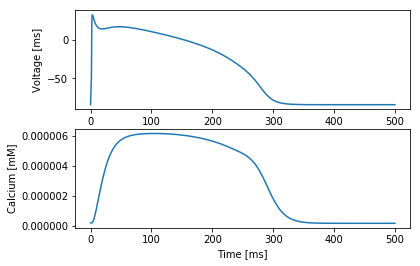

In [5]:
_, axes = plt.subplots(2, 1)
axes[0].plot(times, values[:, 0])
axes[1].plot(times, values[:, 1])
axes[0].set_ylabel('Voltage [ms]')
axes[1].set_ylabel('Calcium [mM]')
axes[1].set_xlabel('Time [ms]')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

In [6]:
# Add noise
values[:, 0] += np.random.normal(0, 1, values[:, 0].shape)
values[:, 1] += np.random.normal(0, 5e-7, values[:, 1].shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries one order of magnitude above and below the suggested values
lower = [x - 2.0 for x in x0]
upper = [x + 2.0 for x in x0]
boundaries = pints.Boundaries(lower, upper)

# Perform an optimization with boundaries and hints
middle = [0.5 * (u + l) for l, u in zip(lower, upper)]
sigma = [u - l for l, u in zip(lower, upper)]
optimiser = pints.Optimisation(score, middle, sigma, boundaries, method=pints.XNES)
optimiser.set_log_to_screen(False)
found_parameters, found_score = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x0[k]))

Found solution:          True parameters:
 1.62106976375754641e+00     1.38629436111989057e+00
-6.06954929742547655e+00    -5.80914299031402770e+00
-6.58768844947696941e-01    -2.40794560865187224e+00
 2.01438994170965557e-01    -1.04982212449867784e+00
 1.40918774191019391e+00    -2.23143551314209709e-01


We can then compare the true and fitted model output

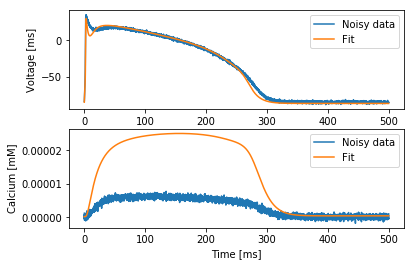

In [9]:
# Evaluate model at found parameters
found_values = problem.evaluate(found_parameters)

# Show quality of fit
_, axes = plt.subplots(2, 1)
axes[0].plot(times, values[:, 0], label='Noisy data')
axes[0].plot(times, found_values[:, 0], label='Fit')
axes[1].plot(times, values[:, 1], label='Noisy data')
axes[1].plot(times, found_values[:, 1], label='Fit')
axes[0].set_ylabel('Voltage [ms]')
axes[1].set_ylabel('Calcium [mM]')
axes[1].set_xlabel('Time [ms]')
axes[0].legend()
axes[1].legend()
plt.show()